In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from tensorflow.contrib import learn
from PIL import Image, ImageDraw
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
from Detector.RetinaNet import RetinaNet
from utils.bbox import draw_boxes

In [3]:
FLAGS = tf.app.flags.FLAGS

tf.logging.set_verbosity(tf.logging.WARN)
tf.app.flags.DEFINE_string('f', '', 'kernel')
#### Input pipeline
tf.app.flags.DEFINE_integer('input_size', 768,
                            """Input size""")
tf.app.flags.DEFINE_integer('batch_size', 1,
                            """Train batch size""")
tf.app.flags.DEFINE_integer('num_classes', 20,
                            """number of classes""")
tf.app.flags.DEFINE_integer('num_gpus', 1,
                            """The number of gpu""")
#tf.app.flags.DEFINE_string('tune_from', 'logs_v1/bn_momen1/model.ckpt-17000',
#                          """Path to pre-trained model checkpoint""")
tf.app.flags.DEFINE_string('tune_from', 'logs_v1/bn_momen3/best_models/model-130600',
                         """Path to pre-trained model checkpoint""")

#### Training config
tf.app.flags.DEFINE_boolean('use_bn', True,
                            """use batchNorm or GroupNorm""")
tf.app.flags.DEFINE_float('cls_thresh', 0.4,
                            """thresh for class""")
tf.app.flags.DEFINE_float('nms_thresh', 0.3,
                            """thresh for nms""")
tf.app.flags.DEFINE_integer('max_detect', 300,
                            """num of max detect (using in nms)""")

In [4]:
img_dir = "/root/DB/ICDAR2013_FOCUSED/test/"
val_list = [im for im in os.listdir(img_dir) if "jpg" in im]

VOC = {1 : "text"}
mode = learn.ModeKeys.INFER

In [5]:
def _get_init_pretrained(sess):
    saver_reader = tf.train.Saver(tf.global_variables())
    saver_reader.restore(sess, FLAGS.tune_from)

infer
MODE :  False
use bn :  True
856128


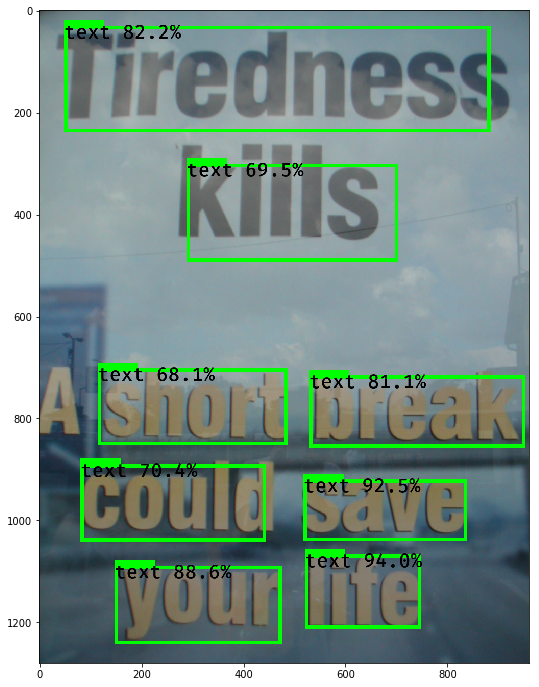

856128


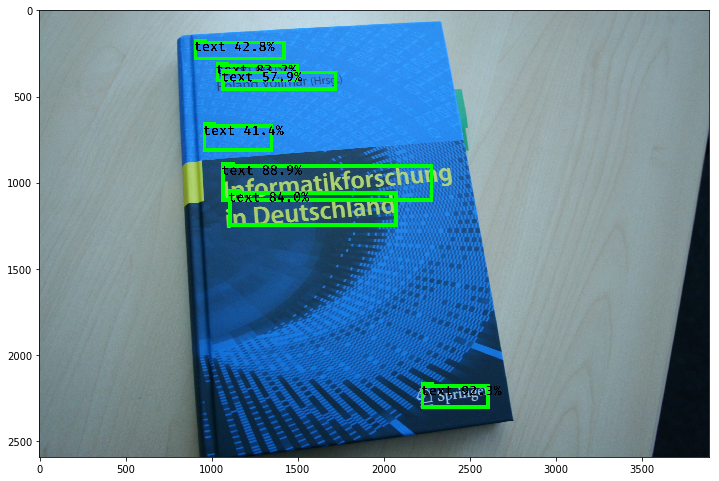

856128


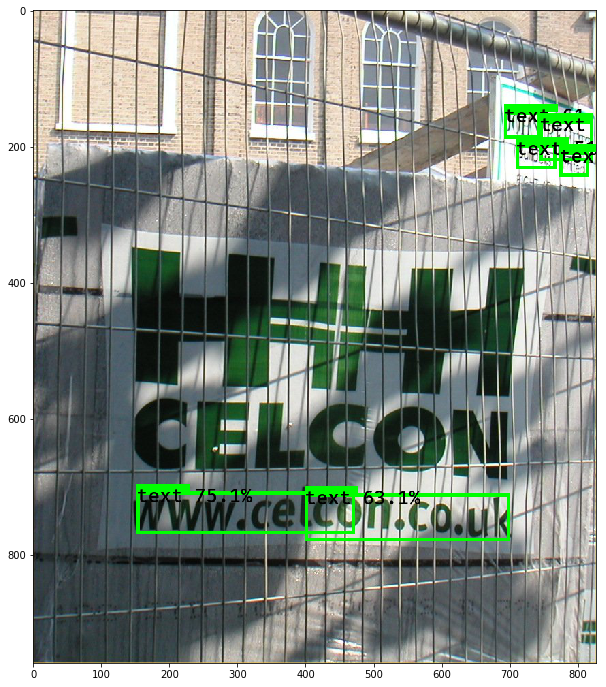

856128


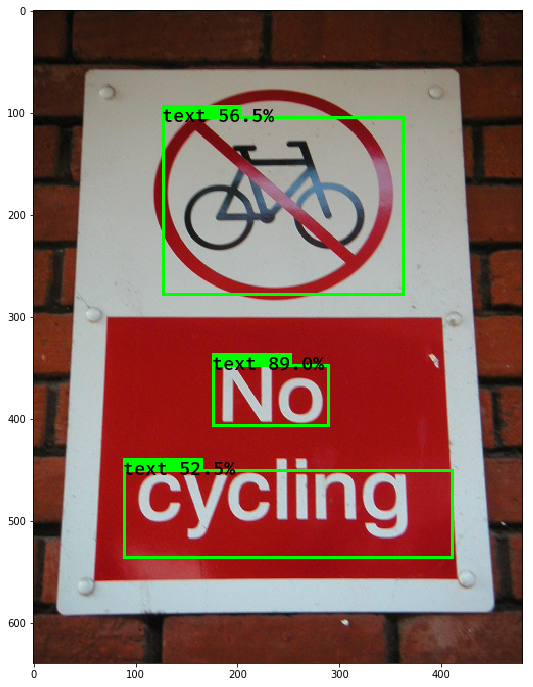

856128


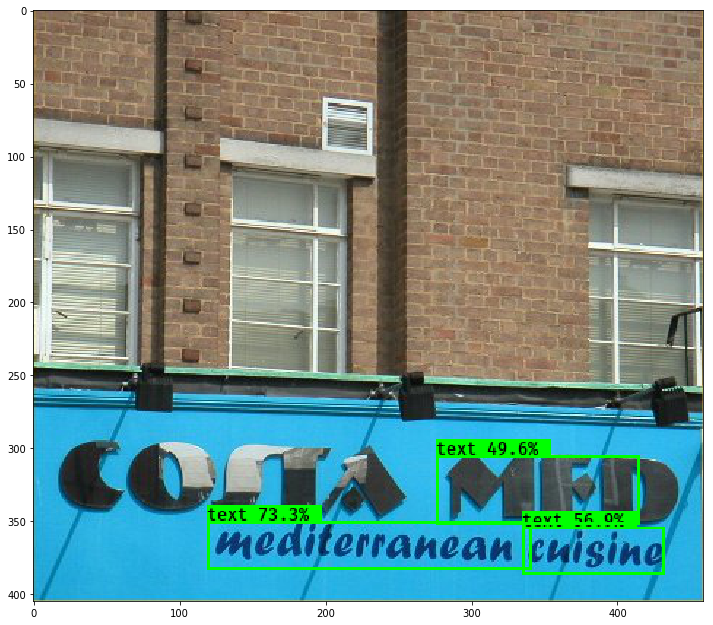

856128


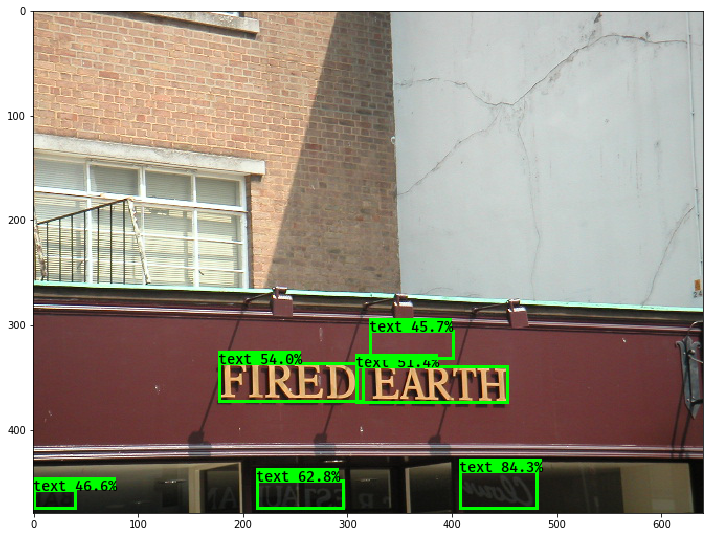

856128


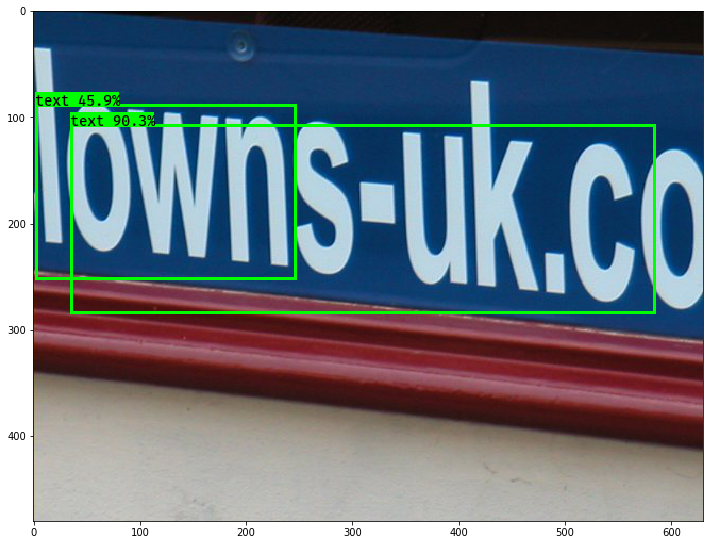

856128


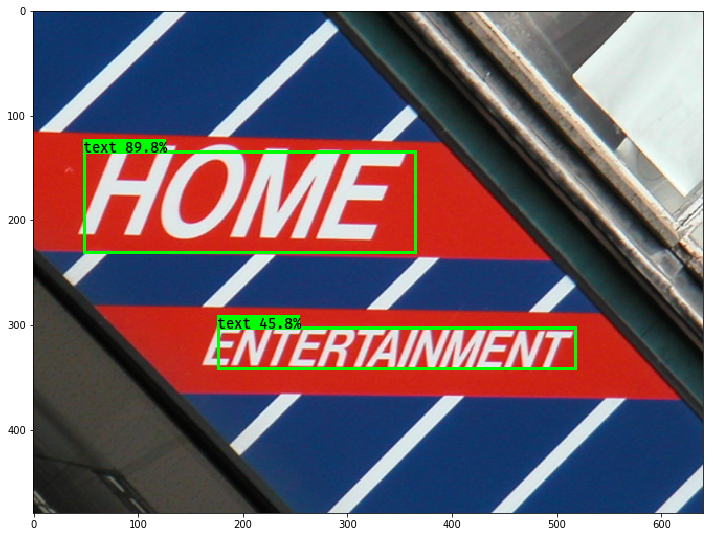

856128


KeyboardInterrupt: 

In [10]:
cls_result = []
loc_result = []

with tf.Graph().as_default():
    _image = tf.placeholder(tf.float32, shape=[None, None, 3], name='image')

    with tf.variable_scope('train_tower_0') as scope:
        net = RetinaNet("resnet50")
        
        image = tf.expand_dims(_image, 0)
        image = tf.to_float(image)
        image /= 255.0
        
        mean = (0.485, 0.456, 0.406)
        var = (0.229, 0.224, 0.225)
        
        image -= mean
        image /= var
        
        image = tf.image.resize_images(image, (FLAGS.input_size, FLAGS.input_size),
                                           method=tf.image.ResizeMethod.BILINEAR)
        
        print(mode)
        box_head, cls_head = net.get_logits(image, mode)

        decode = net.decode(box_head, cls_head)

    #restore_model = get_init_trained()
    init_op = tf.group( tf.global_variables_initializer(),
                        tf.local_variables_initializer())

    classes = set()
    with tf.Session() as sess:
        sess.run(init_op)
        _get_init_pretrained(sess)

        for n, _img in enumerate(val_list):
            img = Image.open(img_dir + _img)

            width, height = img.size

            boxes, labels, scores = sess.run(decode, feed_dict={_image : img})

            box /= FLAGS.input_size
            box *= [height, width, height, width]
            
            for box, score in zip(boxes, scores):
                ymin, xmin, ymax, xmax = box
                loc_result.append([xmin, ymin, xmax, ymax])
                cls_result.append(score)
            
            label = [VOC[l] for l in labels]
            
            img = draw_boxes(img, boxes, labels, scores)
            
            plt.figure(figsize =(12, 12))
            plt.imshow(img)
            plt.show()
            if n==20:
                break
